# The Lancet Countdown: tracking progress on health and climate change

The Lancet Countdown: tracking progress on health and climate change is an international, multidisciplinary research collaboration between academic institutions and practitioners across the world. It follows on from the work of the 2015 Lancet Commission, which concluded that the response to climate change could be “the greatest global health opportunity of the 21st century”. The Lancet Countdown aims to track the health impacts of climate hazards; health resilience and adaptation; health co-benefits of climate change mitigation; economics and finance; and political and broader engagement.

## Subtask 1:  Health impacts of climate hazards


- 1.1 Exposure to temperature change 
- 1.2 Exposure to heatwaves
- 1.3 Changes in labour productivity 
- 1.4 Exposure to flood
- 1.5 Exposure to drought
- 1.6 Changes in the incidence and geographical range of climate-sensitive infectious diseases across sentinel sites
- 1.7 Food security and undernutrition


## Methods

## New analysis - 2017 edition

### Analysis period

- (To start with) 2015 year

### Metric 1.1: Exposure to temperature change

The vulnerability to climate change is a function of the physical hazard (change in temperature, precipitation, humidity etc) and the number of (vulnerable) people exposed. A first order measure of exposure is defined here as:


$$
E(x,t) = \Delta T(x,t)P(x,t)
$$

and the global average is

$$
\bar{E} = \frac{\int \Delta T(x,t)P(x,t) dx}{\int P(x,t) dx}
$$

Where $\Delta T(x,t)$ is the change in the summer mean temperature (Northern Hemisphere JJA, Southern Hemisphere DJF) at location x at time t from the recent historical summer mean (1986-2005). $P(x,t)$ is the population at location x at time t in millions.

**To calculate the number of vulnerable people affected the population is restricted to those over 5 years old who have received no formal education.**

The relative population density was also proposed to calculate the global mean values of exposure;

$$
E(x,t) = \frac{\Delta T(x,t)P(x,t)}{A(x)} / \int P(x,t)A(x) dx
$$

Where A(x) is the area in kilometres at location x, and   $P (x, t)A(x)$ is the global mean population density. This will result in the same qualitative conclusions as equation 1, but the units have been converted from Kelvin millions of people to Kelvin for the exposure maps.

#### Notes, definitions:

Northern Hemisphere JJA: June, July, August

Southern Hemisphere DJF: December, January, February

# TODO

- Cross reference population with weather!
- NASA gridded populations are nice, but might want to confirm with Peter that he thinks they are OK.
    - Main issue is going to be that if you want to factor in demographic data like age and education, simple population won't cut it. That data is likely only going to be available per-country.
    - That's going to mean doing weather averages per-country similar to prev work. Will want to be able to find intersect between country poly and weather grid boundaries - maybe do with PostGIS though would like to try to do it all inside python without DB
    
- Would like to have the 1986-2005 summer mean temperatures - really no point downloading that whole range just to do an average!


# Tech

- GeoPandas might be handy, but maybe a bit buggy?

In [4]:
%matplotlib inline

from pathlib import Path
from datetime import date

import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import rasterio
import fiona

import cartopy
from cartopy import crs

import geopandas as gpd 
from config import DATA_SRC, WEATHER_FILE, CLIMATOLOGY_FILE, SHAPEFILES_SRC
import weather_ecmwf
import util
import config

from config import COUNTRY_POLY_SHP
db = util.DB(config.GIS_DB)


In [5]:
POP_DATA_SRC = DATA_SRC / 'humans' / 'population'


In [3]:
population_grid_2015_file = (POP_DATA_SRC / 'nasa_grid' /'gpw-v4-population-count-adjusted-to-2015-unwpp-country-totals-2015' /
                             'gpw-v4-population-count-adjusted-to-2015-unwpp-country-totals_2015.tif')

In [4]:
START_DATE = date(2015, 1,1)
END_DATE = date(2015, 12, 31)

# Load countries shapes

In [5]:
gpd_countries = gpd.read_file(str(COUNTRY_POLY_SHP))

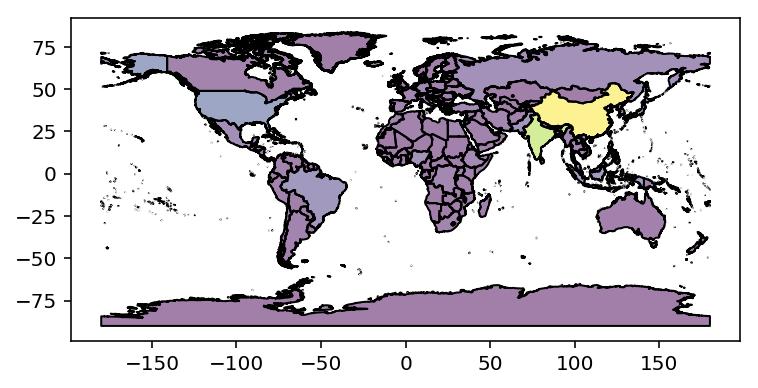

In [6]:
gpd_countries.plot(column='POP_EST')

## Selecting summer from ECMWF

In [8]:
code = gpd_countries.ISO_A3[0]

In [61]:
shp = gpd_countries.loc[0].geometry

In [58]:
gpd_countries.POP_EST[0]

103065.0

In [6]:
era_climatology = weather_ecmwf.climatology_dataset(CLIMATOLOGY_FILE)
era_weather =  weather_ecmwf.weather_dataset(WEATHER_FILE)

In [15]:
# TODO: massive memory usage here :/
# Maybe need to chunk the input files
out = weather_ecmwf.lookup_country_data(db, era_climatology, code, 
                                        grid_table=weather_ecmwf.GridTable.era_climatology_grid
                                       )
climate = out.to_dataframe()


out = weather_ecmwf.lookup_country_data(db, era_weather, code, 
                                        grid_table=weather_ecmwf.GridTable.era_interim_grid
                                       )
weather = out.to_dataframe()



In [50]:
# Weather includes more time stamps than we have in the climatology
# Create a time indexer that will match the climate
synthetic_time = pd.date_range(start='2015-01-01', periods=len(weather), freq='6H')
weather_slice = weather.loc[synthetic_time[:len(climate)]]

In [53]:
t_delta.mean()

0.506683488891989

In [69]:
# north or south hemisphere
if shp.centroid.y >= 0:
    t_months = t_delta[(t_delta.index.month == 6) | (t_delta.index.month == 7) | (t_delta.index.month == 8)]
else:
    t_months = t_delta[(t_delta.index.month == 1) | (t_delta.index.month == 2) | (t_delta.index.month == 12)]



In [70]:
t_months.mean()

0.9442539195387004

In [10]:
# northern hemisphere
lat_north = temperatures.latitude[temperatures.latitude >= 0]
lat_south = temperatures.latitude[temperatures.latitude < 0]

# Summer North
summer_jja = temperatures.time[(temperatures['time.month'] == 6) | (temperatures['time.month'] == 7) | (temperatures['time.month'] == 8)]

# Summer South
summer_djf = temperatures.time[(temperatures['time.month'] == 12) | (temperatures['time.month'] == 1) | (temperatures['time.month'] == 2)]


north_temp = temperatures.sel(latitude=lat_north, time=summer_jja)

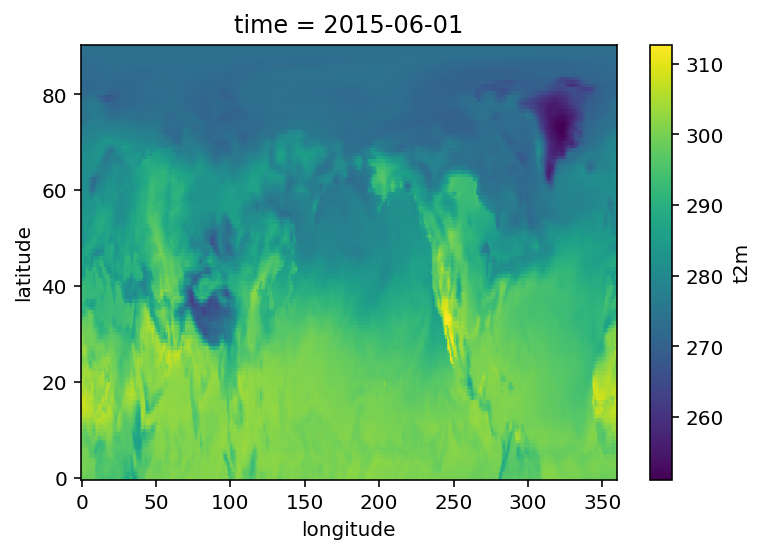

In [11]:
north_temp.isel(time=0).plot()

## Load the geometry grid and points and calculate the intersection


## Load per-country population data

In [20]:
world_bank_yr_pop_file = POP_DATA_SRC / 'API_SP' / 'API_SP.POP.TOTL_DS2_en_csv_v2.csv'

In [21]:
world_bank_pop =  pd.read_csv(world_bank_yr_pop_file)

In [38]:
world_bank_pop = world_bank_pop.rename(columns={'Country Code': 'ISO_A3'})

In [48]:
countries_data[['ISO_A3', 'geometry']].set_index('ISO_A3').join(world_bank_pop.set_index('ISO_A3')[['Country Name', '2015']])

,geometry,Country Name,2015
ISO_A3,,,
-99,(POLYGON ((123.5970158210001 -12.4283179669999...,NaN,NaN
-99,(POLYGON ((-79.98928788999987 15.7949486350000...,NaN,NaN
-99,(POLYGON ((-109.2120255199999 10.3026797550000...,NaN,NaN
-99,(POLYGON ((33.92540165200015 35.06277048700004...,NaN,NaN
-99,(POLYGON ((154.3912866550001 -21.0300432269998...,NaN,NaN
-99,(POLYGON ((32.62620446800022 35.16508982400013...,NaN,NaN
-99,(POLYGON ((33.90586796100013 35.09088246600004...,NaN,NaN
-99,(POLYGON ((55.5013126960001 -20.87322356599999...,NaN,NaN
-99,(POLYGON ((96.9139103520001 -12.19451262799986...,NaN,NaN


# Associate gridded weather with country values

## Load gridded population data

- Warning: big file!
- Note: might prefer to load the half-resolution version with 2x2km pixels, much more managable on laptop

In [100]:
with rasterio.open(str(population_grid_2015_file)) as pop:
    print(pop.meta)
    pop_meta = pop.meta
    trns = pop.transform
    population = pop.read(1, masked=True)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -407649103380480.0, 'width': 43200, 'height': 17400, 'count': 1, 'crs': CRS({'init': 'epsg:4326'}), 'transform': Affine(0.00833333333333339, 0.0, -180.0,
       0.0, -0.00833333333333339, 85.0000000000092)}


# Prototyping: figure out how to multiply weather data by population data

- Using grids this is a bit easier
- Think its mostly about resampling the grids to match -> should this mean averaging pop grid to match weather, or supersampling weather onto pop?
- later, going to want to group grid squares by country

## Notes

- Careful with resampling - scipy zoom broke the thing, memory leak 50+GB before death
- Could resmaple image data using various methods (spline, linear, average over N cells) but none are 'correct', all will introduce some error.
- Also need to be a bit careful because we are dealing with population COUNTS rather than DENSITIES -> results for new sizes pixels should be SUMS of originals, not AVERAGES...


## TODO

Get the old year mean values for summer in north/south and calculate deltaT
